In [ ]:
from __future__ import absolute_import
from __future__  import division
from __future__ import print_function
import tensorflow as tf
import numpy as np
from skimage.io import imread
import cv2
import numpy as np
import os
from PIL import Image
from io import BytesIO
import time
import datetime
import h5py
from random import shuffle
import matplotlib.pyplot as plt

In [ ]:
import zipfile
np.random.seed(12)
import warnings
warnings.filterwarnings('ignore')

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
REPLICAS:  8


In [ ]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import  Dropout, Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

In [ ]:
IMG_SIZE = 128

CHANNELS = 3

NUM_CLASSES = 2

IMG_PER_FILE = 10

epochs = 100



In [ ]:
import os
from random import shuffle

def label_video_names(VideoDataDir, from_part, end_part):

    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []

    CLASSES = ["NonViolence", "Violence"]

    for category in os.listdir(VideoDataDir):
        # Check if the item is a directory and a valid class
        if os.path.isdir(os.path.join(VideoDataDir, category)) and category in CLASSES:
            path = os.path.join(VideoDataDir, category)
            class_num = CLASSES.index(category)
            for i, video in enumerate(os.listdir(path)[from_part:end_part]):
                names.append(video)
                labels.append(class_num)

    c = list(zip(names,labels))

    # Shuffle the data (names and labels)
    shuffle(c)
    names, labels = zip(*c)
    return names, labels

In [ ]:
def video_reader(cv2, filename):
    frames = np.zeros((IMG_PER_FILE, IMG_SIZE, IMG_SIZE, CHANNELS), dtype=np.float16)

    i=0
    #print(frames.shape)
    vc = cv2.VideoCapture(filename)

    #print("reading video")
    while i < IMG_PER_FILE:
        success, frame = vc.read()
        #if success:
        rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frm = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))

        frm = np.expand_dims(frm, axis=0)

        # rescale [0,1]
        frm = frm / 255.0

        frames[i][:] = frm
        i +=1

    datav = np.zeros((1, 10, IMG_SIZE, IMG_SIZE, 3), dtype=np.float16)
    datav[0][:][:] = frames
    return datav

In [ ]:
def handle_exception_video(video):
    video_err = {'NV_940.mp4':'NV_939.mp4'}
    #video =
    if video in video_err:
        return video_err[video]
    else:
        return video

In [ ]:
def processing_data(_from, _to):
    PROJECT_DIR = '/content/real-life-violence-situations-dataset'

    VideoDataDir = PROJECT_DIR
    # print('we have \n{} Violence videos \n{} NonViolence videos'.format(len(os.listdir(VideoDataDir + '/Violence')), len(os.listdir(VideoDataDir + '/NonViolence'))))
    # preprocess name video and labels

    video_names, labels = label_video_names(VideoDataDir, _from, _to)

    X_original = []
    y_original = []

   #print('holdout 500 videos out of 2000, because of memory issue')
    CLASSES = ["NonViolence", "Violence"]
   #500 <- 250 + 250

    for video, label in zip(video_names, labels):
        path = os.path.join(VideoDataDir, CLASSES[label])

        #print((os.path.exists(path)))
        n_video = handle_exception_video(video)

        #print(n_video, end =" ")
        # join final video path
        video_path = os.path.join(path, n_video)
        # read_frame from video
        frames = video_reader(cv2, video_path)

        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(label)

    X_original = np.array(X_original)
    y_original = np.array(y_original)

    y_original = to_categorical(y_original, num_classes=2)


    train_index = int(len(X_original) * 0.8)
    test_index = int(len(y_original) * 0.8)
    X_train, X_val = X_original[:train_index], X_original[test_index:]
    y_train, y_val = y_original[:train_index], y_original[test_index:]
    #X_train = X_train.reshape(-1, 30, IMG_SIZE, IMG_SIZE, 3) / 255
    #X_val = X_val.reshape(-1, 30, IMG_SIZE, IMG_SIZE, 3) / 255

    return X_train, X_val, y_train, y_val

In [ ]:
%%time
from tqdm import tqdm
X_train, X_val, y_train, y_val = processing_data(0, 650)

CPU times: user 1min 14s, sys: 26.6 s, total: 1min 41s
Wall time: 32 s


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(1040, 10, 128, 128, 3)
(1040, 2)
(260, 10, 128, 128, 3)
(260, 2)


In [ ]:
IMG_SIZE = 128

CHANNELS = 3

NUM_CLASSES = 2

IMG_PER_FILE = 10

epochs = 100


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

class AttentionLayer(layers.Layer):
    def __init__(self, units=64, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        # Create trainable weights
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], self.units),
            initializer='random_normal',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(self.units,),
            initializer='zeros',
            trainable=True
        )
        self.u = self.add_weight(
            name='context_vector',
            shape=(self.units, 1),
            initializer='random_normal',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # uit = tanh(W * hit + b)
        uit = tf.tanh(tf.matmul(inputs, self.W) + self.b)

        # ait = softmax(uit * u)
        ait = tf.matmul(uit, self.u)
        attention_weights = tf.nn.softmax(ait, axis=1)

        # Weighted sum of input sequence
        attention_output = inputs * attention_weights
        return tf.reduce_sum(attention_output, axis=1)

    def get_config(self):
        config = super(AttentionLayer, self).get_config()
        config.update({
            'units': self.units
        })
        return config

def create_vgg19_lstm_model_with_attention(img_size=128, channels=3, img_per_file=10, num_classes=2):
    # Input layer for the sequence of images
    input_layer = layers.Input(shape=(img_per_file, img_size, img_size, channels))

    # Base VGG19 model
    base_model = tf.keras.applications.VGG19(
        include_top=False,
        weights='imagenet',
        input_shape=(img_size, img_size, channels)
    )

    # Freeze layers in VGG19 except the last 4 layers
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    # TimeDistributed VGG19 + Global Average Pooling
    x = layers.TimeDistributed(base_model)(input_layer)
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(x)

    # Add Batch Normalization for better training stability
    x = layers.BatchNormalization()(x)

    # First LSTM layer (Bidirectional with 64 units)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True,
                                       dropout=0.3, recurrent_dropout=0.3))(x)

    # Second LSTM layer (Bidirectional with 32 units)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True,
                                       dropout=0.3, recurrent_dropout=0.3))(x)

    # Attention layer
    x = AttentionLayer(units=64)(x)

    # Dense layers with proper regularization
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Output layer
    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    # Create and compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
model = create_vgg19_lstm_model_with_attention()

In [ ]:
# Print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 10, 128, 128, 3   0         
                             )]                                  
                                                                 
 time_distributed_7 (TimeDi  (None, 10, 4, 4, 512)     20024384  
 stributed)                                                      
                                                                 
 time_distributed_8 (TimeDi  (None, 10, 512)           0         
 stributed)                                                      
                                                                 
 batch_normalization (Batch  (None, 10, 512)           2048      
 Normalization)                                                  
                                                                 
 bidirectional_14 (Bidirect  (None, 10, 128)           295424

In [ ]:
patience = 5

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 8

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [ ]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True,
                                 verbose = 1, min_delta = .00075)

lr_plat = ReduceLROnPlateau(patience = 3, mode = 'min')



checkpoint_filepath = 'ModelWeights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

In [ ]:
print('Training head...')


history = model.fit(X_train ,y_train, epochs=epochs,
                    callbacks=callbacks,
                    validation_data = (X_val, y_val),
                    batch_size=batch_size)

print('\nRestoring best Weights for CNN+LSTM')

Training head...
Epoch 1/100
130/130 [==============================] - ETA: 0s - loss: 2.1742 - accuracy: 0.5212
Epoch 1: val_loss improved from inf to 1.82737, saving model to ModelWeights.h5
130/130 [==============================] - 144s 1s/step - loss: 2.1742 - accuracy: 0.5212 - val_loss: 1.8274 - val_accuracy: 0.5885 - lr: 1.0000e-05
Epoch 2/100
130/130 [==============================] - ETA: 0s - loss: 1.8641 - accuracy: 0.6510
Epoch 2: val_loss improved from 1.82737 to 1.75574, saving model to ModelWeights.h5
130/130 [==============================] - 133s 1s/step - loss: 1.8641 - accuracy: 0.6510 - val_loss: 1.7557 - val_accuracy: 0.7308 - lr: 1.8000e-05
Epoch 3/100
130/130 [==============================] - ETA: 0s - loss: 1.6632 - accuracy: 0.7567
Epoch 3: val_loss improved from 1.75574 to 1.67030, saving model to ModelWeights.h5
130/130 [==============================] - 134s 1s/step - loss: 1.6632 - accuracy: 0.7567 - val_loss: 1.6703 - val_accuracy: 0.7615 - lr: 2.6000e-

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

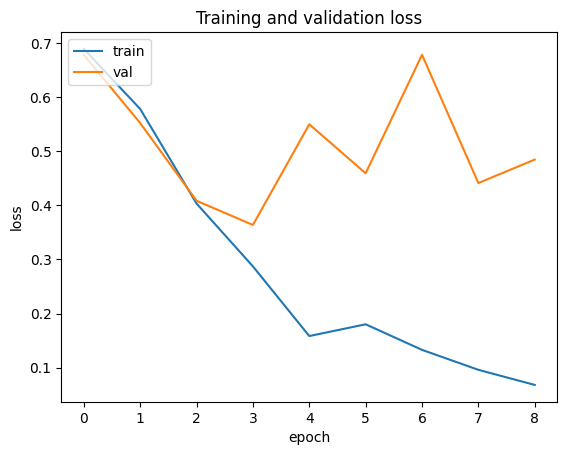

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#prediction

In [ ]:
def pred_fight(model,video,acuracy=0.8538):
    pred_test = model.predict(video)
    if pred_test[0][1] >=acuracy:
        return True , pred_test[0][1]
    else:
        return False , pred_test[0][1]

In [ ]:
def main_fight(video):
    vid = video_reader(cv2,video)
    millis = int(round(time.time() * 1000))
    #print(millis)
    f , precent = pred_fight(model, vid)
    millis2 = int(round(time.time() * 1000))
    #print(millis2)
    res_fight = {'violence':f ,'violence estimation':str(precent)}
    res_fight['processing_time'] =  str(millis2-millis)
    return res_fight

In [ ]:
timer_pred = []
res = []
for i in range(800, 810):
    path = f"/content/real-life-violence-situations-dataset/NonViolence/NV_{i}.mp4"
    pred = main_fight(path)
    res.append(pred['violence estimation'])
    timer_pred.append(pred['processing_time'])

1/1 [==============================] - 0s 137ms/step


In [ ]:
timer_pred

['186', '182', '208', '201', '203', '198', '193', '206', '212', '198']

In [ ]:
res

['0.05537522',
 '0.015890291',
 '0.0077768965',
 '0.014369175',
 '0.003911036',
 '0.012571375',
 '0.04220849',
 '0.21364038',
 '0.14754498',
 '0.49544787']

In [ ]:
timer_pred_v = []
res_v = []
for i in range(800, 810):
    path = f"/content/real-life-violence-situations-dataset/Violence/V_{i}.mp4"
    pred = main_fight(path)
    res_v.append(pred['violence estimation'])
    timer_pred_v.append(pred['processing_time'])

1/1 [==============================] - 0s 124ms/step


In [ ]:
res_v

['0.9834906',
 '0.9931138',
 '0.99296796',
 '0.9648495',
 '0.98325044',
 '0.9879076',
 '0.9922734',
 '0.99171114',
 '0.60335356',
 '0.9781542']

In [ ]:
#Test

In [ ]:
X_t, _, y_t, _ = processing_data(800, 1000)

In [ ]:
print(X_t.shape)
print(y_t.shape)

(315, 10, 128, 128, 3)
(315, 2)


In [ ]:
def predictor(preds):
    return round(preds[0])

In [ ]:
model.load_weights('ModelWeights.h5')
predictions = model.predict(X_t)

NameError: name 'model' is not defined

In [ ]:
preds = np.apply_along_axis(predictor, 1, predictions)
truth = np.apply_along_axis(predictor, 1, y_t)

In [ ]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate the confusion matrix
corr_pred = metrics.confusion_matrix(truth, preds)

# Calculate the number of correct and wrong predictions
n_correct = int(corr_pred[0][0] + corr_pred[1][1])
n_wrongs = int(corr_pred[0][1] + corr_pred[1][0])

print('> Correct Predictions:', n_correct)
print('> Wrong Predictions:', n_wrongs)

# Print the classification report
report = metrics.classification_report(truth, preds, target_names=["NonViolence", "Violence"])
print(report)

> Correct Predictions: 268
> Wrong Predictions: 47
              precision    recall  f1-score   support

 NonViolence       0.83      0.87      0.85       154
    Violence       0.87      0.83      0.85       161

    accuracy                           0.85       315
   macro avg       0.85      0.85      0.85       315
weighted avg       0.85      0.85      0.85       315



In [ ]:
corr_pred = np.array([[143,18],[15,144]])

> Correct Predictions: 287
> Wrong Predictions: 33


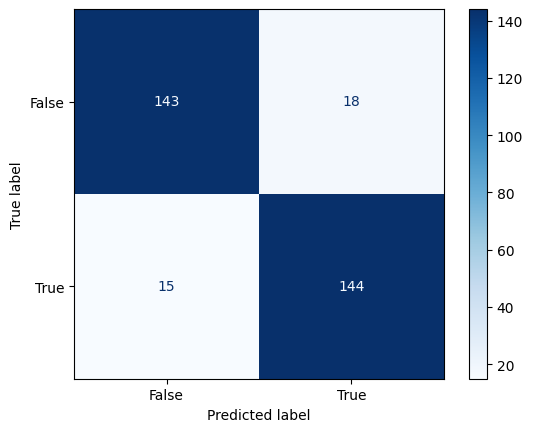

In [ ]:
from sklearn import metrics

#confusion_matrix = metrics.confusion_matrix(truth, preds)
n_correct = int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = corr_pred, display_labels = [False, True])
cm_display.plot(cmap=plt.cm.Blues)
#cm_display.plot()
plt.show()

In [ ]:
validation_steps = 20

print("Evaluate on test data")

results = model.evaluate(x=X_t, y=y_t, steps =validation_steps)
print("test loss, test acc:", results)

Evaluate on test data
20/20 [==============================] - 21s 1s/step - loss: 0.3253 - accuracy: 0.8508
test loss, test acc: [0.3253031075000763, 0.8507936596870422]


In [ ]:
model.save('model.h5')

In [ ]:
from IPython.display import FileLink
FileLink('model.h5')

/content/model.h5

In [ ]:
def preprocess_frames(frames, input_size):
    preprocessed_frames = []

    for frame in frames:
        # Resize the frame to match the input size
        frame = cv2.resize(frame, input_size)

        # Normalize the pixel values to be in the range [0, 1]
        frame = frame / 255.0

        preprocessed_frames.append(frame)

    return preprocessed_frames

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from IPython.display import display, Video
from google.colab import files
def predict_violence(model_path, num_frames=10, frame_shape=(224, 224, 3)):
    """
    This function takes a video input, processes it, and predicts whether it contains violence or not
    using a pre-trained CNN+LSTM model.

    Args:
    - video_path: Path to the video to analyze.
    - model_path: Path to the pre-trained model (.h5 file).
    - num_frames: Number of frames to sample from the video.
    - frame_shape: The shape to resize frames to (should match model input).

    Returns:
    - prediction_label: A string, either 'Violence' or 'Non-Violence'.
    """
    # This will prompt you to upload a video file
    uploaded = files.upload()

# Now play the video
    video_path = list(uploaded.keys())[0]
    # Load your trained CNN+LSTM model
    model = load_model(model_path)

    # Initialize a list to store preprocessed frames
    frames = []

    # Open the video
    cap = cv2.VideoCapture(video_path)

    # Read frames from the video
    for _ in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess the frame (resize to match model input size)
        frame = cv2.resize(frame, frame_shape[:-1])
        frames.append(frame)

    # Close the video file
    cap.release()

    # Preprocess the frames to match the input requirements of your model
    preprocessed_frames = preprocess_frames(frames, (128, 128))  # Assuming you have a preprocessing function

    # Convert the frames to an array and add a batch dimension
    input_data = np.array(preprocessed_frames)[np.newaxis, ...]  # Add a batch dimension

    # Perform the prediction
    predictions = model.predict(input_data)

    # Interpret the predictions (assume thresholding is applied for classification)
    predicted_class = np.argmax(predictions)
    prediction_label = "Violence" if predicted_class == 1 else "Non-Violence"

    print(f"Prediction: {prediction_label}")

    # Play the video after making the prediction
    #play_video(video_path)
    play_video(video_path)
    return prediction_label


def preprocess_frames(frames, input_size):
    preprocessed_frames = []

    for frame in frames:
        # Resize the frame to match the input size
        frame = cv2.resize(frame, input_size)

        # Normalize the pixel values to be in the range [0, 1]
        frame = frame / 255.0

        preprocessed_frames.append(frame)

    return preprocessed_frames




def play_video(video_path):
    """
    Play video in Google Colab using the IPython display method.
    """
    # Display the video directly in the notebook
    display(Video(video_path, embed=True, width=1920, height=1080))




In [ ]:

model_path = 'model.h5'

predict_violence(model_path)

Saving V_1.mp4 to V_1.mp4
1/1 [==============================] - 1s 1s/step
Prediction: Non-Violence


'Non-Violence'

In [ ]:
predict_violence(model_path)

Saving V_142.mp4 to V_142.mp4
1/1 [==============================] - 1s 1s/step
Prediction: Violence


'Violence'

In [ ]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.8 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from IPython.display import display, Video
from google.colab import files
from mtcnn import MTCNN
import matplotlib.pyplot as plt

def predict_violence_and_extract_faces(model_path, num_frames=10, frame_shape=(224, 224, 3)):
    """
    This function takes a video input, processes it for violence detection,
    and if violence is detected, extracts faces from the violent frames.

    Args:
    - model_path: Path to the pre-trained violence detection model (.h5 file).
    - num_frames: Number of frames to sample from the video.
    - frame_shape: The shape to resize frames to (should match model input).

    Returns:
    - prediction_label: A string, either 'Violence' or 'Non-Violence'.
    - extracted_faces: List of extracted face images if violence is detected.
    """
    # Upload video file
    uploaded = files.upload()
    video_path = list(uploaded.keys())[0]

    # Load models
    violence_model = load_model(model_path)
    face_detector = MTCNN()

    # Initialize lists
    frames = []
    original_frames = []
    extracted_faces = []

    # Open the video
    cap = cv2.VideoCapture(video_path)

    # Read frames from the video
    for _ in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            break

        # Store original frame for face detection
        original_frames.append(frame.copy())  # Store original size frames for face detection

        # Preprocess frame for violence detection
        frame_resized = cv2.resize(frame, frame_shape[:-1])  # Resize to match model input
        frames.append(frame_resized)

    # Close the video file
    cap.release()

    # Preprocess frames for violence detection
    preprocessed_frames = preprocess_frames(frames, (128, 128))  # Violence detection model input size
    input_data = np.array(preprocessed_frames)[np.newaxis, ...]  # Add batch dimension

    # Perform violence prediction
    predictions = violence_model.predict(input_data)
    predicted_class = np.argmax(predictions)
    prediction_label = "Violence" if predicted_class == 1 else "Non-Violence"

    print(f"Prediction: {prediction_label}")

    # If violence is detected, extract faces
    if prediction_label == "Violence":
        print("Extracting faces from violent frames...")
        for frame in original_frames:  # Use original frames for face detection
            # Convert frame to RGB (MTCNN expects RGB)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Detect faces
            faces = face_detector.detect_faces(frame_rgb)

            for face in faces:
                x, y, width, height = face['box']
                x, y = max(0, x), max(0, y)  # Ensure coordinates are valid
                face_img = frame[y:y+height, x:x+width]
                if face_img.size > 0:  # Check if face extraction was successful
                    extracted_faces.append(face_img)

        # Display extracted faces
        if extracted_faces:
            display_extracted_faces(extracted_faces)
        else:
            print("No faces were extracted from the violent frames.")

    # Play the video
    play_video(video_path)

    return prediction_label, extracted_faces

def preprocess_frames(frames, input_size):
    preprocessed_frames = []
    for frame in frames:
        frame = cv2.resize(frame, input_size)  # Resize for violence detection model
        frame = frame / 255.0  # Normalize pixel values
        preprocessed_frames.append(frame)
    return preprocessed_frames

def play_video(video_path):
    display(Video(video_path, embed=True, width=1920, height=1080))

def display_extracted_faces(faces, max_faces=10):
    """
    Display extracted faces in a grid layout
    """
    n = min(len(faces), max_faces)
    cols = 3
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(15, 5*rows))
    for i, face in enumerate(faces[:max_faces]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.suptitle('Extracted Faces from Violent Frames', fontsize=16)
    plt.show()


Saving mixkit-married-couple-violently-arguing-4522-hd-ready.mp4 to mixkit-married-couple-violently-arguing-4522-hd-ready.mp4
1/1 [==============================] - 1s 1s/step
Prediction: Violence
Extracting faces from violent frames...
1/1 [==============================] - 0s 30ms/step


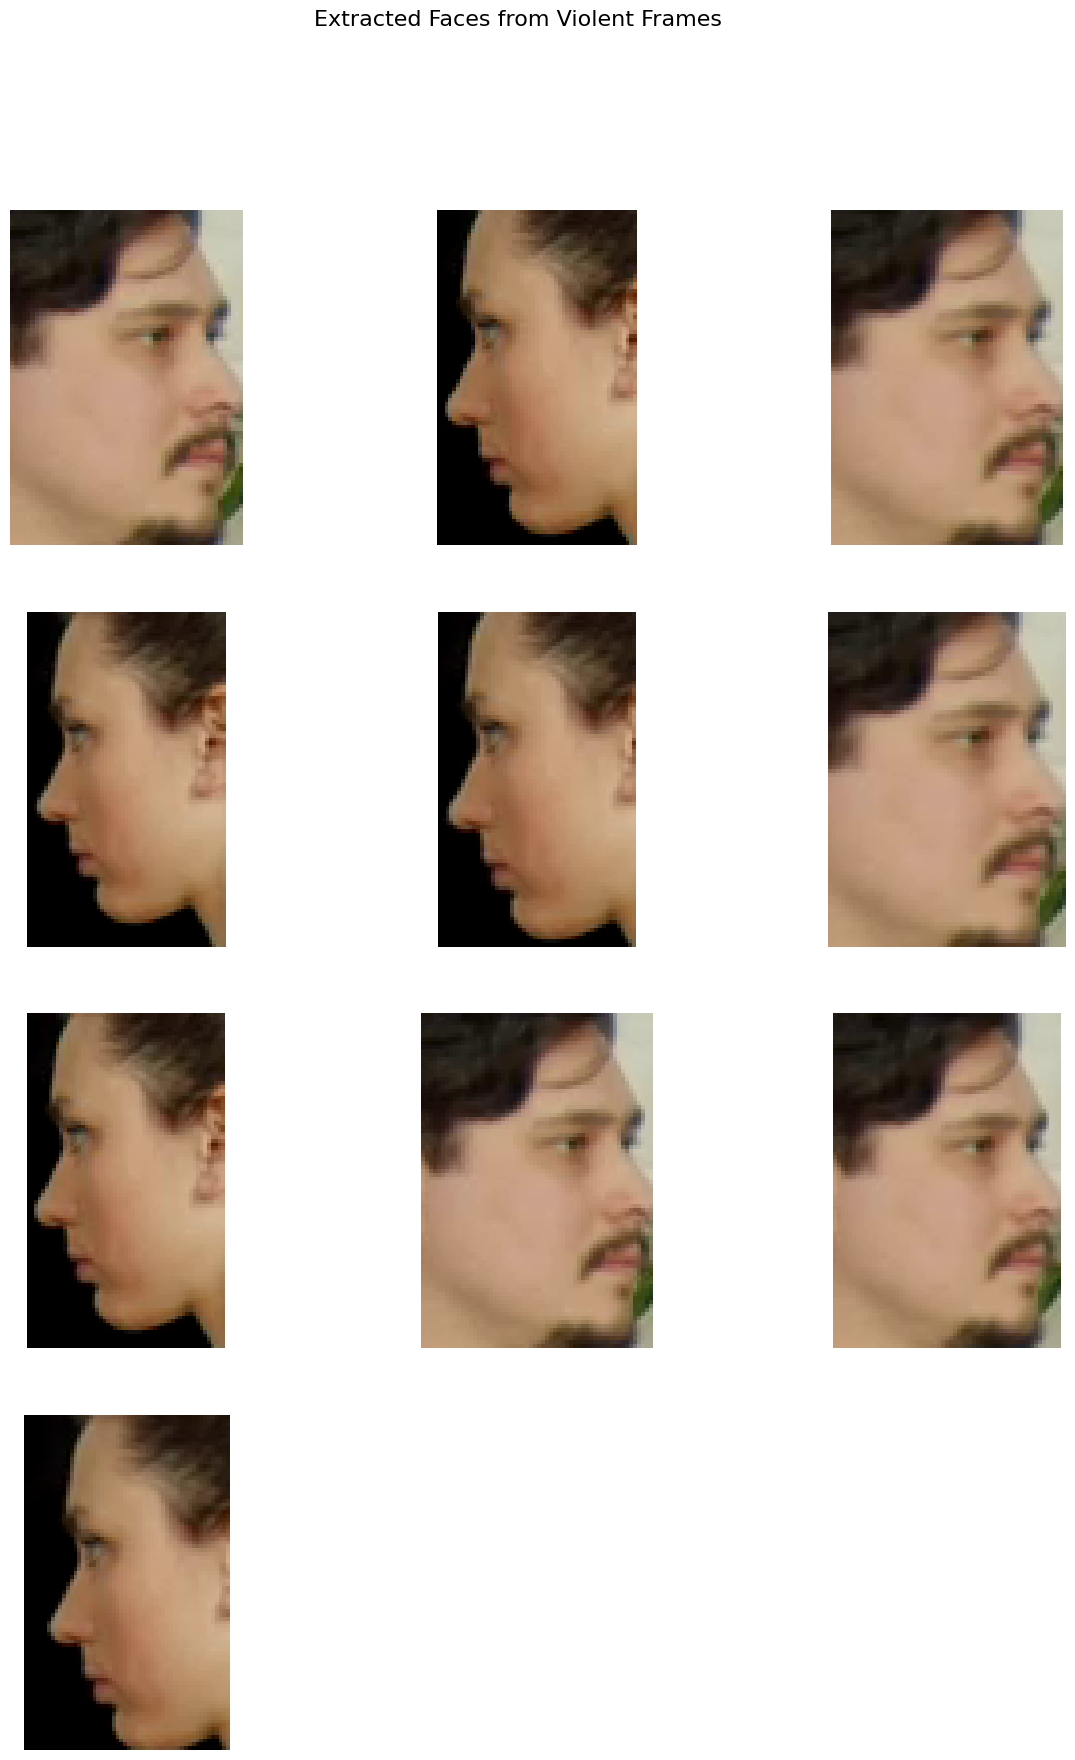

('Violence',
 [array([[[ 20,  23,  28],
          [ 25,  28,  33],
          [ 26,  29,  34],
          ...,
          [183, 202, 201],
          [183, 202, 201],
          [183, 202, 201]],
  
         [[ 26,  29,  34],
          [ 27,  30,  35],
          [ 27,  30,  35],
          ...,
          [183, 202, 201],
          [183, 202, 201],
          [183, 202, 201]],
  
         [[ 23,  33,  37],
          [ 21,  31,  35],
          [ 22,  30,  34],
          ...,
          [182, 201, 200],
          [182, 201, 200],
          [182, 201, 200]],
  
         ...,
  
         [[122, 155, 191],
          [122, 155, 191],
          [122, 155, 191],
          ...,
          [136, 163, 164],
          [134, 161, 162],
          [133, 163, 163]],
  
         [[121, 156, 194],
          [121, 156, 194],
          [121, 156, 194],
          ...,
          [138, 163, 164],
          [138, 163, 164],
          [138, 163, 164]],
  
         [[122, 157, 195],
          [122, 157, 195],
          [

In [ ]:
predict_violence_and_extract_faces(model_path)

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from IPython.display import display, Video
from google.colab import files
from mtcnn import MTCNN
import matplotlib.pyplot as plt

def predict_violence_and_extract_faces(model_path, num_frames=10, frame_shape=(224, 224, 3)):
    """
    This function processes video input for violence detection and extracts the clearest face for each person.

    Args:
    - model_path: Path to the pre-trained violence detection model (.h5 file).
    - num_frames: Number of frames to sample from the video.
    - frame_shape: The shape to resize frames to (should match model input).

    Returns:
    - prediction_label: A string, either 'Violence' or 'Non-Violence'.
    - extracted_faces: List of extracted face images, one per person.
    """
    # Upload video file
    uploaded = files.upload()
    video_path = list(uploaded.keys())[0]

    # Load models
    violence_model = load_model(model_path)
    face_detector = MTCNN()

    # Initialize lists
    frames = []
    original_frames = []
    extracted_faces = []
    known_faces = []  # To store known faces (bounding boxes)

    # Open the video
    cap = cv2.VideoCapture(video_path)

    # Read frames from the video
    for _ in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            break

        # Store original frame for face detection
        original_frames.append(frame.copy())  # Store original size frames for face detection

        # Preprocess frame for violence detection
        frame_resized = cv2.resize(frame, frame_shape[:-1])  # Resize to match model input
        frames.append(frame_resized)

    # Close the video file
    cap.release()

    # Preprocess frames for violence detection
    preprocessed_frames = preprocess_frames(frames, (128, 128))  # Violence detection model input size
    input_data = np.array(preprocessed_frames)[np.newaxis, ...]  # Add batch dimension

    # Perform violence prediction
    predictions = violence_model.predict(input_data)
    predicted_class = np.argmax(predictions)
    prediction_label = "Violence" if predicted_class == 1 else "Non-Violence"

    print(f"Prediction: {prediction_label}")

    # Extract faces from all frames
    print("Extracting faces from frames...")
    for frame in original_frames:  # Use original frames for face detection
        # Convert frame to RGB (MTCNN expects RGB)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Detect faces
        faces = face_detector.detect_faces(frame_rgb)

        for face in faces:
            x, y, width, height = face['box']
            x, y = max(0, x), max(0, y)  # Ensure coordinates are valid
            face_img = frame[y:y+height, x:x+width]

            if face_img.size > 0:  # Check if face extraction was successful
                # Compute sharpness (clarity) of the face
                clarity = calculate_clarity(face_img)

                # Check if this face is a duplicate based on bounding box overlap
                if is_new_face(face['box'], known_faces):
                    known_faces.append((clarity, face['box'], face_img))  # Store clarity, bounding box, and face image
                else:
                    # If duplicate, update with clearer image if needed
                    replace_with_clearer_face(face['box'], clarity, face_img, known_faces)

    # Keep only the clearest face for each detected person
    clearest_faces = [face for clarity, box, face in sorted(known_faces, key=lambda x: -x[0])]

    # Display extracted faces
    if clearest_faces:
        display_extracted_faces(clearest_faces)
    else:
        print("No faces were extracted from the frames.")

    # Play the video
    play_video(video_path)

    return prediction_label, clearest_faces

def preprocess_frames(frames, input_size):
    """
    Resize and normalize frames for the violence detection model.
    """
    preprocessed_frames = []
    for frame in frames:
        frame = cv2.resize(frame, input_size)  # Resize for violence detection model
        frame = frame / 255.0  # Normalize pixel values
        preprocessed_frames.append(frame)
    return preprocessed_frames

def calculate_clarity(image):
    """
    Calculate the clarity (sharpness) of an image using the variance of the Laplacian.
    """
    return cv2.Laplacian(image, cv2.CV_64F).var()

def is_new_face(bbox, known_faces, iou_threshold=0.3):
    """
    Check if the detected face is new by comparing bounding boxes using Intersection over Union (IoU).
    """
    for _, known_bbox, _ in known_faces:
        iou = calculate_iou(bbox, known_bbox)
        if iou > iou_threshold:
            return False  # If IoU is high, it's likely the same person
    return True

def replace_with_clearer_face(bbox, clarity, face_img, known_faces):
    """
    Replace the face in known_faces with a clearer one if needed.
    """
    for i, (known_clarity, known_bbox, known_face_img) in enumerate(known_faces):
        iou = calculate_iou(bbox, known_bbox)
        if iou > 0.3:  # If faces overlap
            if clarity > known_clarity:  # If the new face is clearer
                known_faces[i] = (clarity, bbox, face_img)
            return

def calculate_iou(bbox1, bbox2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    """
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    # Calculate the coordinates of the intersection rectangle
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0  # No overlap

    # Calculate area of intersection
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate area of both bounding boxes
    bbox1_area = w1 * h1
    bbox2_area = w2 * h2

    # Calculate IoU
    iou = intersection_area / float(bbox1_area + bbox2_area - intersection_area)
    return iou

def play_video(video_path):
    """
    Play the video file using IPython display.
    """
    display(Video(video_path, embed=True, width=1920, height=1080))

def display_extracted_faces(faces, max_faces=10):
    """
    Display extracted faces in a grid layout.
    """
    n = min(len(faces), max_faces)
    cols = 3
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(15, 5*rows))
    for i, face in enumerate(faces[:max_faces]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.suptitle('Extracted Faces from Frames', fontsize=16)
    plt.show()

# Example usage:
# Call this function to upload a video and extract the clearest faces for each person
prediction_label, clearest_faces = predict_violence_and_extract_faces('/content/model.h5', num_frames=100)  # Adjust num_frames as needed


Saving mixkit-married-couple-violently-arguing-4522-hd-ready.mp4 to mixkit-married-couple-violently-arguing-4522-hd-ready (1).mp4


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        Number of samples per batch.
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        Args:
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        verbose="auto",
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 10, 128, 128, 3), found shape=(None, 100, 128, 128, 3)


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from IPython.display import display, Video
from google.colab import files
from mtcnn import MTCNN
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
# Import VGGFace and necessary modules
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

# Load VGGFace model for face embeddings
vggface_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

def predict_violence_and_extract_faces(model_path, num_frames=10, frame_shape=(224, 224, 3)):
    """
    This function processes video input for violence detection and extracts the clearest face for each person.

    Args:
    - model_path: Path to the pre-trained violence detection model (.h5 file).
    - num_frames: Number of frames to sample from the video.
    - frame_shape: The shape to resize frames to (should match model input).

    Returns:
    - prediction_label: A string, either 'Violence' or 'Non-Violence'.
    - extracted_faces: List of extracted face images, one per person.
    """
    # Upload video file
    uploaded = files.upload()
    video_path = list(uploaded.keys())[0]

    # Load models
    violence_model = load_model(model_path)
    face_detector = MTCNN()

    # Initialize lists
    frames = []
    original_frames = []
    extracted_faces = []
    known_face_embeddings = []

    # Open the video
    cap = cv2.VideoCapture(video_path)

    # Read frames from the video
    for _ in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            break

        # Store original frame for face detection
        original_frames.append(frame.copy())  # Store original size frames for face detection

        # Preprocess frame for violence detection
        frame_resized = cv2.resize(frame, frame_shape[:-1])  # Resize to match model input
        frames.append(frame_resized)

    # Close the video file
    cap.release()

    # Preprocess frames for violence detection
    preprocessed_frames = preprocess_frames(frames, (128, 128))  # Violence detection model input size
    input_data = np.array(preprocessed_frames)[np.newaxis, ...]  # Add batch dimension

    # Perform violence prediction
    predictions = violence_model.predict(input_data)
    predicted_class = np.argmax(predictions)
    prediction_label = "Violence" if predicted_class == 1 else "Non-Violence"

    print(f"Prediction: {prediction_label}")

    # Extract faces from all frames
    print("Extracting faces from frames...")
    for frame in original_frames:  # Use original frames for face detection
        # Convert frame to RGB (MTCNN expects RGB)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Detect faces
        faces = face_detector.detect_faces(frame_rgb)

        for face in faces:
            x, y, width, height = face['box']
            x, y = max(0, x), max(0, y)  # Ensure coordinates are valid
            face_img = frame[y:y+height, x:x+width]

            if face_img.size > 0:  # Check if face extraction was successful
                # Compute sharpness (clarity) of the face
                clarity = calculate_clarity(face_img)

                # Compute face embedding using VGGFace
                face_img_resized = cv2.resize(face_img, (224, 224))
                face_embedding = get_face_embedding(face_img_resized)

                # Check if this face is a duplicate by comparing with known faces
                if is_new_face(face_embedding, known_face_embeddings):
                    known_face_embeddings.append(face_embedding)
                    extracted_faces.append((clarity, face_img))
                else:
                    # If duplicate, update with clearer image if needed
                    replace_with_clearer_face(face_embedding, clarity, face_img, extracted_faces, known_face_embeddings)

    # Keep only the clearest face for each detected person
    clearest_faces = [face for _, face in sorted(extracted_faces, key=lambda x: -x[0])]

    # Display extracted faces
    if clearest_faces:
        display_extracted_faces(clearest_faces)
    else:
        print("No faces were extracted from the frames.")

    # Play the video
    play_video(video_path)

    return prediction_label, clearest_faces

def preprocess_frames(frames, input_size):
    """
    Resize and normalize frames for the violence detection model.
    """
    preprocessed_frames = []
    for frame in frames:
        frame = cv2.resize(frame, input_size)  # Resize for violence detection model
        frame = frame / 255.0  # Normalize pixel values
        preprocessed_frames.append(frame)
    return preprocessed_frames

def get_face_embedding(face_img):
    """
    Get the face embedding using VGGFace model.
    """
    face_img = np.expand_dims(face_img, axis=0)
    face_img = preprocess_input(face_img, version=2)  # VGGFace ResNet50 preprocessing
    return vggface_model.predict(face_img)[0]  # Extract the embedding

def calculate_clarity(image):
    """
    Calculate the clarity (sharpness) of an image using the variance of the Laplacian.
    """
    return cv2.Laplacian(image, cv2.CV_64F).var()

def is_new_face(face_embedding, known_face_embeddings, threshold=0.5):
    """
    Check if the face is new by comparing its embedding to known embeddings.
    """
    if not known_face_embeddings:
        return True

    similarities = cosine_similarity([face_embedding], known_face_embeddings)
    return np.all(similarities < threshold)

def replace_with_clearer_face(face_embedding, clarity, face_img, extracted_faces, known_face_embeddings):
    """
    Replace the face in extracted_faces with a clearer one if needed.
    """
    for i, known_embedding in enumerate(known_face_embeddings):
        similarity = cosine_similarity([face_embedding], [known_embedding])[0][0]
        if similarity >= 0.5:  # If faces are similar
            if clarity > extracted_faces[i][0]:  # If the new face is clearer
                extracted_faces[i] = (clarity, face_img)
            return

def play_video(video_path):
    """
    Play the video file using IPython display.
    """
    display(Video(video_path, embed=True, width=1920, height=1080))

def display_extracted_faces(faces, max_faces=10):
    """
    Display extracted faces in a grid layout.
    """
    n = min(len(faces), max_faces)
    cols = 3
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(15, 5*rows))
    for i, face in enumerate(faces[:max_faces]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.suptitle('Extracted Faces from Frames', fontsize=16)
    plt.show()

# Example usage:
# Call this function to upload a video and extract the clearest faces for each person
prediction_label, clearest_faces = predict_violence_and_extract_faces('/content/model.h5', num_frames=100)  # Adjust num_frames as needed


ImportError: cannot import name 'layer_utils' from 'keras.utils' (/usr/local/lib/python3.10/dist-packages/keras/utils/__init__.py)

In [ ]:

# Step 1: Integrating OpenPose for Pose Estimation
# This cell will preprocess each video frame using OpenPose to extract skeletal keypoints.

import cv2
import numpy as np
from openpose import pyopenpose as op

# Set up OpenPose parameters
params = dict()
params["model_folder"] = "/path/to/openpose/models/"  # Update this path as needed

# Initialize OpenPose
opWrapper = op.WrapperPython()
opWrapper.configure(params)
opWrapper.start()

def extract_pose_keypoints(frame):
    datum = op.Datum()
    datum.cvInputData = frame
    opWrapper.emplaceAndPop([datum])
    return datum.poseKeypoints if datum.poseKeypoints is not None else np.zeros((1, 25, 3))

# Example: Process frames to get pose keypoints
pose_data = []
for frame in video_frames:  # Assume video_frames is the list of frames for a video
    keypoints = extract_pose_keypoints(frame)
    pose_data.append(keypoints)

pose_data = np.array(pose_data)  # Shape: (num_frames, num_keypoints, keypoint_dims)


In [ ]:

# Step 2: VGG19 for Frame-Level Feature Extraction
# Using VGG19 pre-trained on ImageNet to extract features from each frame.

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

# Initialize VGG19 model
vgg19 = VGG19(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
vgg19.trainable = False

def extract_vgg19_features(frame):
    img_array = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = vgg19.predict(img_array)
    return features.flatten()

# Process each frame and extract VGG19 features
vgg_features = [extract_vgg19_features(frame) for frame in video_frames]
vgg_features = np.array(vgg_features)  # Shape: (num_frames, feature_dim)


In [ ]:

# Step 3: Bi-LSTM with Attention Layer
# Combine VGG19 features and pose keypoints, then apply Bi-LSTM with an attention layer.

from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Attention, Input, Concatenate
from tensorflow.keras.models import Model

# Define input shapes
vgg_input = Input(shape=(vgg_features.shape[1],))
pose_input = Input(shape=(pose_data.shape[1], pose_data.shape[2]))

# Concatenate VGG and pose features
merged_features = Concatenate()([vgg_input, pose_input])

# Apply Bi-LSTM with attention
lstm_output = Bidirectional(LSTM(64, return_sequences=True))(merged_features)
attention_output = Attention()([lstm_output, lstm_output])

# Final dense layer for classification
output = Dense(NUM_CLASSES, activation="softmax")(attention_output)
model = Model(inputs=[vgg_input, pose_input], outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:

# Step 4: GAN for Predictive Analysis
# A simple GAN setup to predict future frames based on VGG and LSTM features.

from tensorflow.keras.layers import LeakyReLU, Conv2DTranspose
from tensorflow.keras.models import Sequential

# Define Generator model
def build_generator():
    generator = Sequential([
        Dense(128, activation="relu", input_shape=(100,)),
        Dense(256, activation="relu"),
        Dense(512, activation="relu"),
        Dense(np.prod((IMG_SIZE, IMG_SIZE, CHANNELS)), activation="tanh"),
        Reshape((IMG_SIZE, IMG_SIZE, CHANNELS))
    ])
    return generator

# Define Discriminator model
def build_discriminator():
    discriminator = Sequential([
        Flatten(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS)),
        Dense(512, activation="relu"),
        Dense(256, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    return discriminator

# Instantiate GAN
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Combine models for GAN training
gan_input = Input(shape=(100,))
generated_image = generator(gan_input)
discriminator.trainable = False
gan_output = discriminator(generated_image)
gan_model = Model(gan_input, gan_output)
gan_model.compile(optimizer="adam", loss="binary_crossentropy")

# GAN usage for predictive analysis
# Generate future frames based on current sequence of features.


In [ ]:

# Step 5: Efficiency Improvements
# Apply model pruning and quantization to optimize for real-time performance.

from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude

# Example of pruning a dense layer
pruned_model = prune_low_magnitude(model, pruning_schedule=...)

# Quantize model to reduce computational requirements
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save quantized model for real-time use
with open("optimized_model.tflite", "wb") as f:
    f.write(quantized_tflite_model)


In [ ]:

# Import necessary libraries
import cv2
import matplotlib.pyplot as plt

# Load a pre-trained face detector model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to perform face detection and display result
def detect_and_display_face(image):
    # Convert image to grayscale for face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    # Draw rectangle around each detected face
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
    # Display the result
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [ ]:

# Save the model and weights
model.save('face_detection_model.h5')  # Save the entire model
model.save_weights('face_detection_weights.h5')  # Save model weights only


In [ ]:

# Function to display frames with detected violence and timestamps
def display_violence_frame(frame, timestamp):
    # Annotate the frame with the timestamp and overlay for violence
    cv2.putText(frame, f"Violence detected at {timestamp} seconds", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (0, 0, 255), 2, cv2.LINE_AA)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
